In [1]:
%%html
<iframe style="aspect-ratio: 1200 / 630; width:100%; height:fit-content;" src="https://www.coindesk.com/embedded-chart/GRdgwdpLtpFTd" width="100%" frameborder="0" scrolling="no"></iframe>

# Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import sys
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.utils import plot_model

In [3]:
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from utils import \
    get_binance_klines, \
    plot_time_series, \
    custom_plot_series, \
    evaluate_preds, \
    get_labelled_windows, \
    make_windows, \
    make_train_test_splits

# Get Data

In [4]:
symbol = 'BTCUSDT'
interval = '1d'
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

df = get_binance_klines(symbol, interval, start_date, end_date)

if df is not None:
    # Define the full path to the file in the data folder
    data_dir = '../data/'
    csv_file = os.path.join(data_dir, 'binance_btcusdt_price_history.csv')
    
    # Save the data to a CSV file in the data folder
    df.to_csv(csv_file, index=False)
    print(f"Historical Bitcoin price data from Binance downloaded and saved to '{csv_file}'")

    # Get the last element of the DataFrame
    last_element = df.iloc[-1]
    print("\nLast element of the DataFrame:")
    print(last_element)

Historical Bitcoin price data from Binance downloaded and saved to '../data/binance_btcusdt_price_history.csv'

Last element of the DataFrame:
open                                 56714.61000000
high                                 58296.00000000
low                                  56289.45000000
close                                57952.01000000
volume                               26940.40133000
close_time                            1720569599999
quote_asset_volume              1546417754.79067130
number_of_trades                            1701256
taker_buy_base_asset_volume          13704.88548000
taker_buy_quote_asset_volume     786815885.03483770
ignore                                            0
Name: 2024-07-09 00:00:00, dtype: object


The bitcoin historical data in [Binance](https://www.binance.com/en) starts in **2017-08-17**

In [5]:
df.head()

open           high            low          close  \
Date                                                                     
2017-08-17  4261.48000000  4485.39000000  4200.74000000  4285.08000000   
2017-08-18  4285.08000000  4371.52000000  3938.77000000  4108.37000000   
2017-08-19  4108.37000000  4184.69000000  3850.00000000  4139.98000000   
2017-08-20  4120.98000000  4211.08000000  4032.62000000  4086.29000000   
2017-08-21  4069.13000000  4119.62000000  3911.79000000  4016.00000000   

                   volume     close_time quote_asset_volume  number_of_trades  \
Date                                                                            
2017-08-17   795.15037700  1503014399999   3454770.05073206              3427   
2017-08-18  1199.88826400  1503100799999   5086958.30617151              5233   
2017-08-19   381.30976300  1503187199999   1549483.73542151              2153   
2017-08-20   467.08302200  1503273599999   1930364.39032646              2321   
2017-08-21   691.74306000  1503359999999   2797231.71402728              3972   

           taker_buy_base_asset_volume taker_buy_quote_asset_volume ignore  
Date                                                                        
2017-08-17                616.24854100             2678216.40060401      0  
2017-08-18                972.86871000             4129123.31651808      0  
2017-08-19                274.33604200             1118001.87008735      0  
2017-08-20                376.79594700             1557401.33373730      0  
2017-08-21                557.35610700             2255662.55315837      0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2519 entries, 2017-08-17 to 2024-07-09
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open                          2519 non-null   object
 1   high                          2519 non-null   object
 2   low                           2519 non-null   object
 3   close                         2519 non-null   object
 4   volume                        2519 non-null   object
 5   close_time                    2519 non-null   int64 
 6   quote_asset_volume            2519 non-null   object
 7   number_of_trades              2519 non-null   int64 
 8   taker_buy_base_asset_volume   2519 non-null   object
 9   taker_buy_quote_asset_volume  2519 non-null   object
 10  ignore                        2519 non-null   object
dtypes: int64(2), object(9)
memory usage: 236.2+ KB


In [7]:
len(df)

2519

In [8]:
btc_prices = pd.DataFrame(df['close']).rename(columns={'close': 'Price'})
btc_prices['Price'] = btc_prices['Price'].astype(float)
btc_prices.head()

Price
Date               
2017-08-17  4285.08
2017-08-18  4108.37
2017-08-19  4139.98
2017-08-20  4086.29
2017-08-21  4016.00

### Visualize !

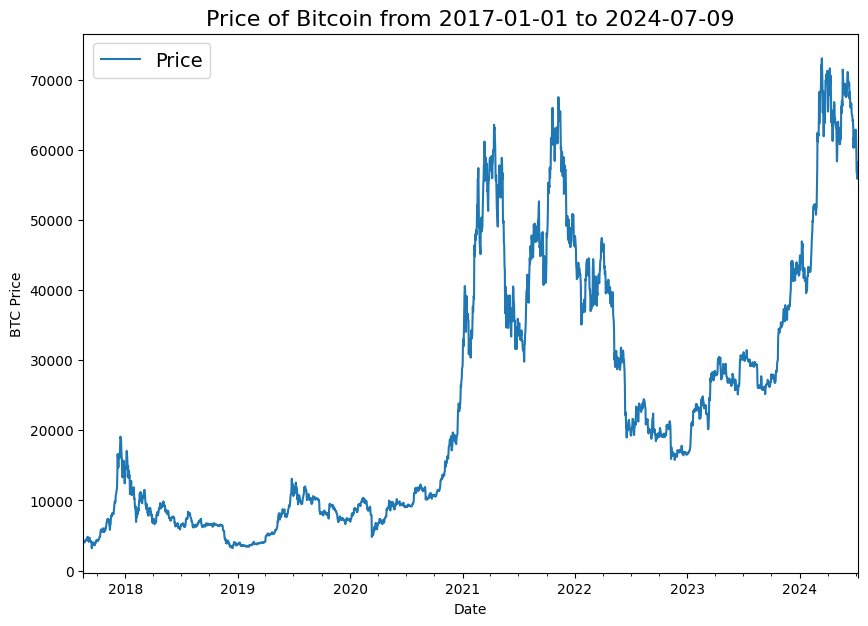

In [9]:
btc_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title(f"Price of Bitcoin from {start_date} to {end_date}", fontsize=16)
plt.legend(fontsize=14);

# Create train & test sets for time series

In [10]:
# Get bitcoin date array
timesteps = btc_prices.index.to_numpy()
prices = btc_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2017-08-17T00:00:00.000000000', '2017-08-18T00:00:00.000000000',
        '2017-08-19T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
        '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
        '2017-08-23T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
        '2017-08-25T00:00:00.000000000', '2017-08-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([4285.08, 4108.37, 4139.98, 4086.29, 4016.  , 4040.  , 4114.01,
        4316.01, 4280.68, 4337.44]))

In [11]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2015, 504, 2015, 504)

Let's visualize

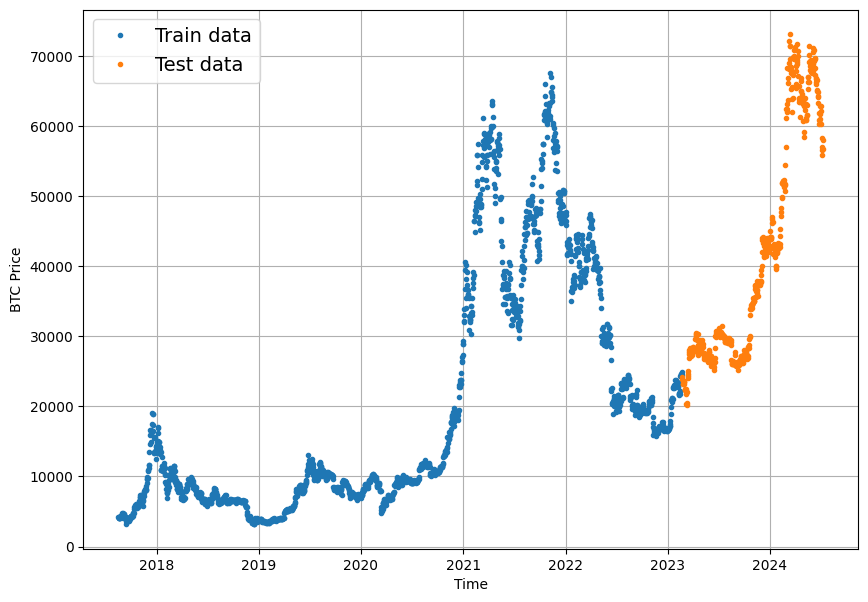

In [12]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling Experiments

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict **horizon**

<table style="width: 100%">
    <tr>
        <th style="text-align: center; vertical-align: middle;">Model Number</th>
        <th style="text-align: center; vertical-align: middle;">Model Type</th>
        <th style="text-align: center; vertical-align: middle;">Horizon size</th>
        <th style="text-align: center; vertical-align: middle;">Window size</th>
        <th style="text-align: center; vertical-align: middle;">Extra data</th>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">0</td>
        <td style="text-align: center; vertical-align: middle;">Forecasting with sktime (baseline)</td>
        <td style="text-align: center; vertical-align: middle;">0.5% data ‚âà 13</td>
        <td style="text-align: center; vertical-align: middle;">25</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">Dense model</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">2</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">3</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">4</td>
        <td style="text-align: center; vertical-align: middle;">Conv1D</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">5</td>
        <td style="text-align: center; vertical-align: middle;">LSTM</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">6</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with multivariate data)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">Block reward size</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;"><a href="https://arxiv.org/pdf/1905.10437.pdf">N-BEATs Algorithm</a></td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">8</td>
        <td style="text-align: center; vertical-align: middle;">Ensemble (multiple models optimized on different loss functions)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">9</td>
        <td style="text-align: center; vertical-align: middle;">Future prediction model (model to predict future values)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
</table>

## Model 0: Forecasting with sktime (baseline)

In [13]:
# Concatenate the train and test sets
dates = np.concatenate((X_train, X_test))
prices = np.concatenate((y_train, y_test))

# Create a DataFrame
data = pd.DataFrame({"Date": dates, "Price": prices})

# Ensure the Date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
# Split the data into training and test sets
y_train_baseline, y_test_baseline = temporal_train_test_split(data['Price'], test_size=0.005)

In [15]:
# Create the regressor
regressor = KNeighborsRegressor(n_neighbors=3)

# Create the forecasting model using make_reduction
forecaster = make_reduction(regressor, window_length=25, strategy="direct")

In [16]:
fh = [i for i in range(1, len(y_test_baseline) + 1)]

# Fit the model
forecaster.fit(y_train_baseline, fh=fh)

# Make predictions
y_pred_baseline = forecaster.predict(fh)

In [17]:
model_0_results = evaluate_preds(y_true=y_test_baseline, y_pred=y_pred_baseline)
model_0_results

Mean Absolute Error (MAE): 3154.6556
Mean Squared Error (MSE): 13642809.4938
Root Mean Squared Error (RMSE): 3693.6174
R^2 Score: -1.3054


{'MAE': 3154.6556410256408,
 'MSE': 13642809.493790597,
 'RMSE': 3693.61739948666,
 'R2': -1.3053664038333639}

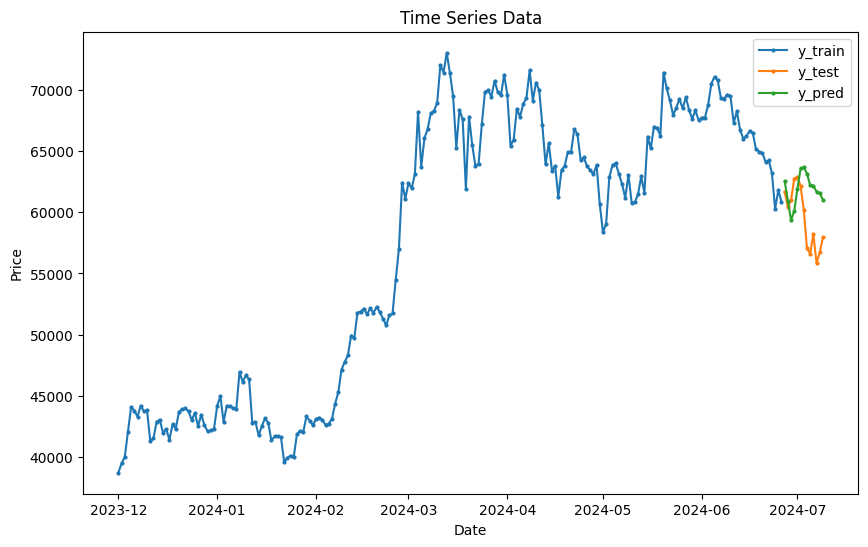

In [18]:
# Plot the predictions
start = pd.to_datetime("2023-12-01")
custom_plot_series(y_train_baseline, y_test_baseline, y_pred_baseline, start=start, marker_size=2)

# Preprocessing data

## Windowing dataset

Example: Window for one week (univariate time series)
```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [20]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2512, 2512)

In [22]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [4285.08 4108.37 4139.98 4086.29 4016.   4040.   4114.01] -> Label: [4316.01]
Window: [4108.37 4139.98 4086.29 4016.   4040.   4114.01 4316.01] -> Label: [4280.68]
Window: [4139.98 4086.29 4016.   4040.   4114.01 4316.01 4280.68] -> Label: [4337.44]


In [23]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [62772.01 62899.99 62135.47 60208.58 57050.01 56628.79 58230.13] -> Label: [55857.81]
Window: [62899.99 62135.47 60208.58 57050.01 56628.79 58230.13 55857.81] -> Label: [56714.62]
Window: [62135.47 60208.58 57050.01 56628.79 58230.13 55857.81 56714.62] -> Label: [57952.01]


## Turning windows into training and test sets

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2009, 503, 2009, 503)

## Make a modelling checkpoint

In [25]:
def create_model_checkpoint(model_name, save_path="../models"):
    """
    Creates a callback to save the model checkpoint.

    Parameters:
    - model_name: str
        Name of the model.
    - save_path: str, optional (default="models")
        Directory to save the model file.

    Returns:
    - tf.keras.callbacks.ModelCheckpoint
        ModelCheckpoint callback object.
    """
    # Ensure model_name ends with .keras
    if not model_name.endswith('.keras'):
        model_name += '.keras'

    # Construct the filepath to save the model
    filepath = os.path.join(save_path, model_name)

    # Return ModelCheckpoint callback
    return tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                               verbose=0,
                                               save_best_only=True)

# Model 1: Dense model (window = 7, horizon = 1) 

In [26]:
# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                     
], name="model_1_dense") # give the model a name so we can save it

In [27]:
# Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [28]:
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - loss: 17949.4277 - mae: 17949.4277 - val_loss: 3701.8931 - val_mae: 3701.8931
Epoch 2/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 2378.0164 - mae: 2378.0164 - val_loss: 1900.6844 - val_mae: 1900.6844
Epoch 3/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 1628.1743 - mae: 1628.1743 - val_loss: 2373.5095 - val_mae: 2373.5095
Epoch 4/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 1221.0740 - mae: 1221.0740 - val_loss: 1542.5770 - val_mae: 1542.5770
Epoch 5/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 1122.5320 - mae: 1122.5320 - val_loss: 1430.0914 - val_mae: 1430.0914
Epoch 6/100
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 1051.7089 - mae: 1051.7089 - val_loss: 1404.1071 - val

In [29]:
model_1.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 339us/step - loss: 564.3801 - mae: 564.3801


[761.2377319335938, 761.2377319335938]

In [30]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("../models/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 399us/step - loss: 548.8828 - mae: 548.8828


[744.3855590820312, 744.3855590820312]

In [31]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [32]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 875us/step


(503,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([24252.984, 23937.613, 23333.352, 23103.945, 23411.543, 23503.441,
        23212.861, 23521.04 , 23494.182, 22599.69 ], dtype=float32)>)

In [33]:
model_1_preds = tf.cast(model_1_preds, tf.float64)

In [34]:
tf.squeeze(test_labels).dtype, model_1_preds.dtype

(tf.float64, tf.float64)

In [35]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

Mean Absolute Error (MAE): 744.3855
Mean Squared Error (MSE): 1402107.5337
Root Mean Squared Error (RMSE): 1184.1062
R^2 Score: 0.9946


{'MAE': 744.3855304112824,
 'MSE': 1402107.5336500215,
 'RMSE': 1184.1062172161844,
 'R2': 0.9946111858246435}

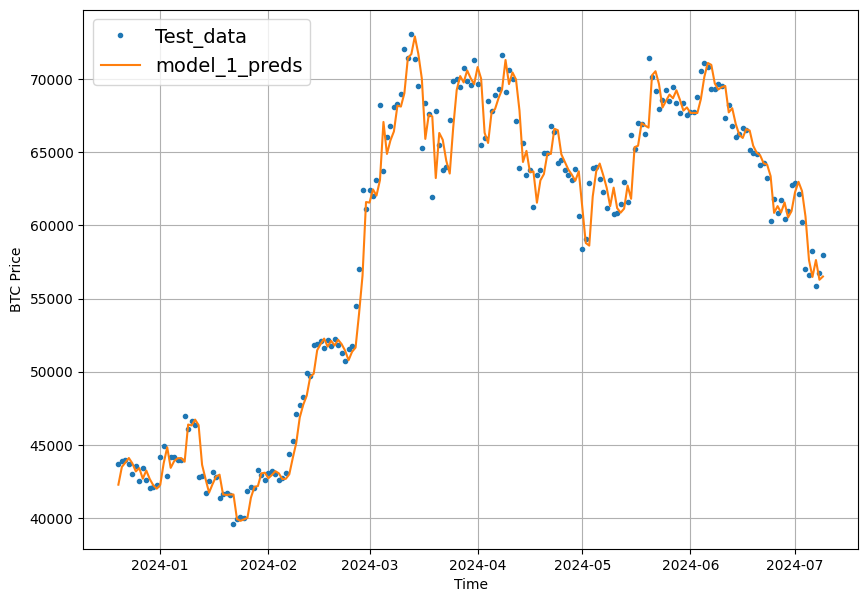

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model 2: Dense (window = 30, horizon = 1)

In [37]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [38]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2489, 2489)

In [39]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1991, 498, 1991, 498)

In [40]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [41]:
model_2.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 321us/step - loss: 565.8791


765.203125

In [42]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("../models/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 326us/step - loss: 565.8791


765.203125

In [43]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 864us/step


In [44]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

Mean Absolute Error (MAE): 765.2030
Mean Squared Error (MSE): 1458405.8153
Root Mean Squared Error (RMSE): 1207.6447
R^2 Score: 0.9944


{'MAE': 765.2030001255018,
 'MSE': 1458405.8152658148,
 'RMSE': 1207.6447388474041,
 'R2': 0.994381603754533}

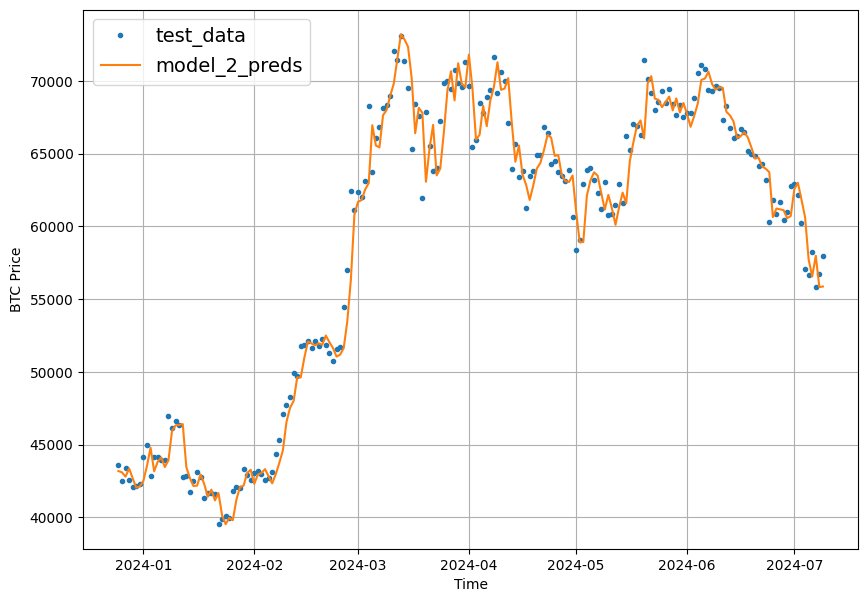

In [45]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

# Model 3: Dense (window = 30, horizon = 7)

In [46]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2483, 2483)

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1986, 497, 1986, 497)

In [48]:
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [49]:
model_3.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 285us/step - loss: 1275.8336


1646.995361328125

In [50]:
# Load in saved best performing model_3 and evaluate on test data
model_3 = tf.keras.models.load_model("../models/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 329us/step - loss: 1215.0922


1569.9390869140625

In [51]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 777us/step


In [52]:
test_labels.shape, model_3_preds.shape

((497, 7), TensorShape([497, 7]))

In [53]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

Mean Absolute Error (MAE): 1569.9392
Mean Squared Error (MSE): 5605418.0109
Root Mean Squared Error (RMSE): 2367.5764
R^2 Score: 0.9784


{'MAE': 1569.9391803275,
 'MSE': 5605418.010888004,
 'RMSE': 2367.576400221966,
 'R2': 0.9784190103037016}

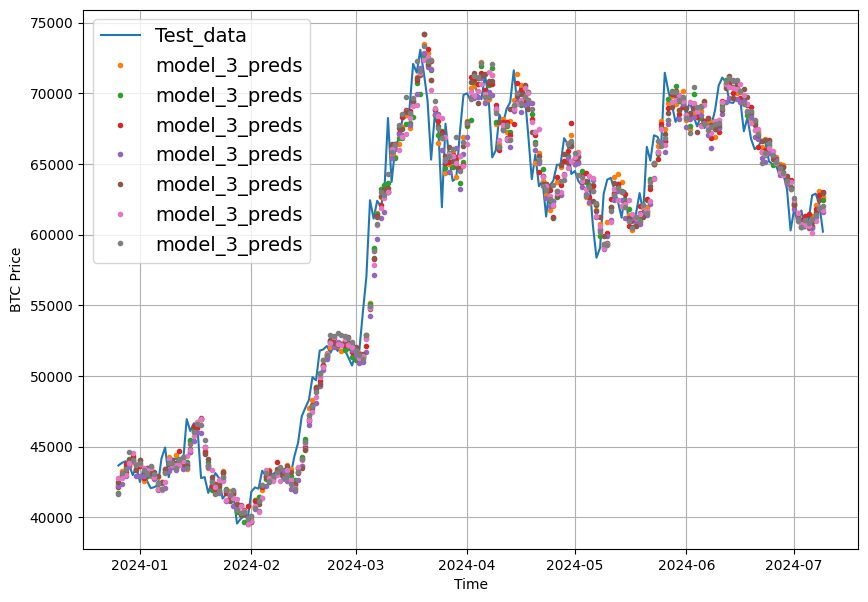

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], format="-", values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

Reduce the dimensionality of model_3 preds with ```tf.reduce.mean(...)```

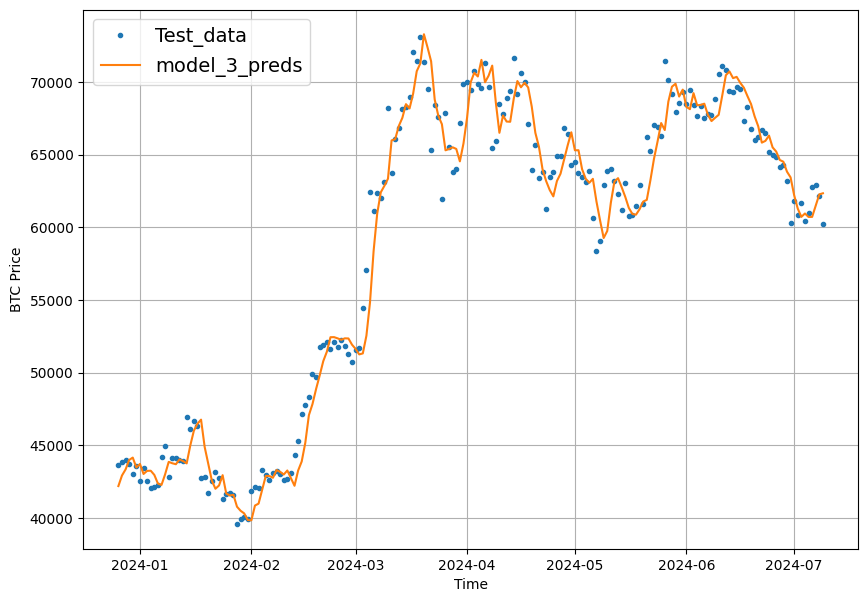

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 format=".",
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

Which model is performing best so far?

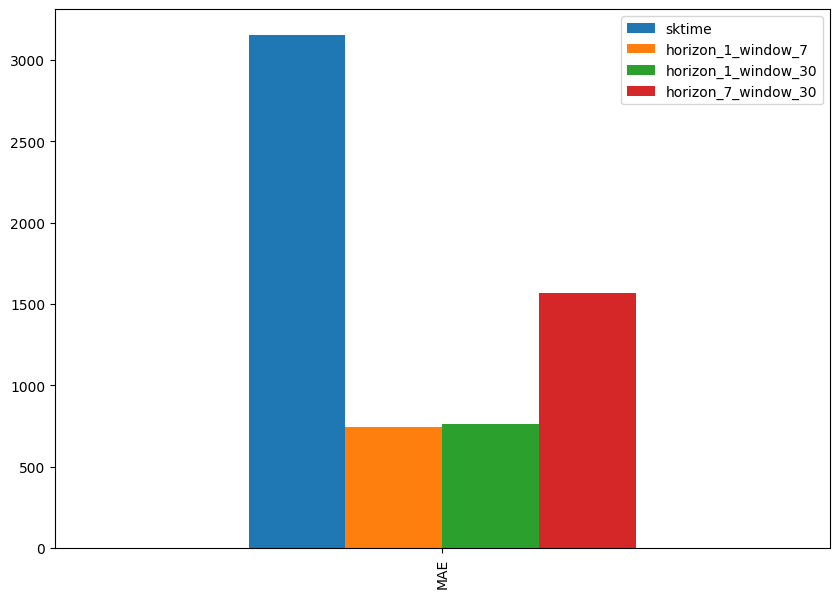

In [56]:
pd.DataFrame({"sktime": model_0_results["MAE"], 
              "horizon_1_window_7": model_1_results["MAE"], 
              "horizon_1_window_30": model_2_results["MAE"], 
              "horizon_7_window_30": model_3_results["MAE"]}, index=["MAE"]).plot(figsize=(10, 7), kind="bar");

# Model 4: Conv1D

In [57]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [58]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2512, 2512)

In [59]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2009, 503, 2009, 503)

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In [60]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[4285.08]
 [4108.37]
 [4139.98]
 [4086.29]
 [4016.  ]
 [4040.  ]
 [4114.01]]


In [61]:
# Create model
model_4 = tf.keras.Sequential([
    layers.Input(shape=(7,)),  # Define input shape explicitly
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [62]:
model_4.summary()

Model: "model_4_conv1D"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lambda_1 (Lambda)               ‚îÇ (None, 1, 7)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)                 ‚îÇ (None, 1, 128)         ‚îÇ         4,608 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 1, 1)           ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [63]:
# Get forecast predictions
model_4_preds = make_preds(model_4,
                           input_data=test_windows)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 


In [64]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

Mean Absolute Error (MAE): 1043.6296
Mean Squared Error (MSE): 2109105.5931
Root Mean Squared Error (RMSE): 1452.2760
R^2 Score: 0.9919


{'MAE': 1043.629642147117,
 'MSE': 2109105.5931042056,
 'RMSE': 1452.2760044510153,
 'R2': 0.9918939326373517}

# Model 5: RNN (LSTM)

In [65]:
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=(1, 7))(inputs) # expand input dimension to be compatible with LSTM
print(x.shape)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
print(x.shape)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

(None, 1, 7)
(None, 128)


In [66]:
# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [67]:
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [68]:
model_5.summary()

Model: "model_5_lstm"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_4 (InputLayer)      ‚îÇ (None, 7)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lambda_2 (Lambda)               ‚îÇ (None, 1, 7)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 128)            ‚îÇ        69,632 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         4,128 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 221,381 (864.77 KB)

 Trainable params: 73,793 (288.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,588 (576.52 KB)

In [69]:
# Get forecast predictions
model_5_preds = make_preds(model_5,
                           input_data=test_windows)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step


In [70]:
# Evaluate predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

Mean Absolute Error (MAE): 759.1320
Mean Squared Error (MSE): 1437607.9025
Root Mean Squared Error (RMSE): 1199.0029
R^2 Score: 0.9945


{'MAE': 759.1319675695825,
 'MSE': 1437607.9024937854,
 'RMSE': 1199.0028784343203,
 'R2': 0.9944747448696779}

# Make a multivariate time series

In [71]:
btc_prices.head()

Price
Date               
2017-08-17  4285.08
2017-08-18  4108.37
2017-08-19  4139.98
2017-08-20  4086.29
2017-08-21  4016.00

Create a DataFrame for the Bitcoin halving data

In [72]:
halving_data = {
    "": ["Halving 1", "Halving 2", "Halving 3", "Halving 4"],
    "Height of the block": [210000, 420000, 630000, 840000],
    "Date": ["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-20"],
    "Block reward (BTC)": [25, 12.5, 6.25, 3.125]
}

In [73]:
# Create a DataFrame for the Bitcoin halving data
halving_df = pd.DataFrame(halving_data)
halving_df

Height of the block        Date  Block reward (BTC)
0  Halving 1               210000  2012-11-28              25.000
1  Halving 2               420000  2016-07-09              12.500
2  Halving 3               630000  2020-05-11               6.250
3  Halving 4               840000  2024-04-20               3.125

 Halving 1 isn't in our dataset (it starts from 2017-08-17)

In [74]:
halving_df.dtypes

                        object
Height of the block      int64
Date                    object
Block reward (BTC)     float64
dtype: object

In [75]:
btc_prices.dtypes

Price    float64
dtype: object

In [76]:
# Convert the "Date" column to datetime format for better manipulation
halving_df['Date'] = pd.to_datetime(halving_df['Date'], errors='coerce')

# Set the Date column as the index of the DataFrame
halving_df.set_index('Date', inplace=True)

In [77]:
halving_df

Height of the block  Block reward (BTC)
Date                                                          
2012-11-28  Halving 1               210000              25.000
2016-07-09  Halving 2               420000              12.500
2020-05-11  Halving 3               630000               6.250
2024-04-20  Halving 4               840000               3.125

In [78]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (halving_df.index[2] - btc_prices.index[0]).days
block_reward_3_days = (halving_df.index[3] - btc_prices.index[0]).days

block_reward_2_days, block_reward_3_days

(998, 2438)

In [79]:
# Add block_reward column
btc_prices_block = btc_prices.copy()
btc_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
btc_prices_block.iloc[:block_reward_2_days, -1] = halving_df['Block reward (BTC)'][1]
btc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = halving_df['Block reward (BTC)'][2]
btc_prices_block.iloc[block_reward_3_days:, -1] = halving_df['Block reward (BTC)'][3]

/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_24432/4002739709.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_prices_block.iloc[:block_reward_2_days, -1] = halving_df['Block reward (BTC)'][1]
/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_24432/4002739709.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = halving_df['Block reward (BTC)'][2]
/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_24432/4002739709.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

In [80]:
btc_prices_block[::365]

Price block_reward
Date                             
2017-08-17   4285.08         12.5
2018-08-17   6584.49         12.5
2019-08-17  10216.02         12.5
2020-08-16  11911.00         6.25
2021-08-16  45901.29         6.25
2022-08-16  23854.74         6.25
2023-08-16  28730.51         6.25

In [81]:
btc_prices_block.value_counts('block_reward')

block_reward
6.250     1440
12.500     998
3.125       81
Name: count, dtype: int64

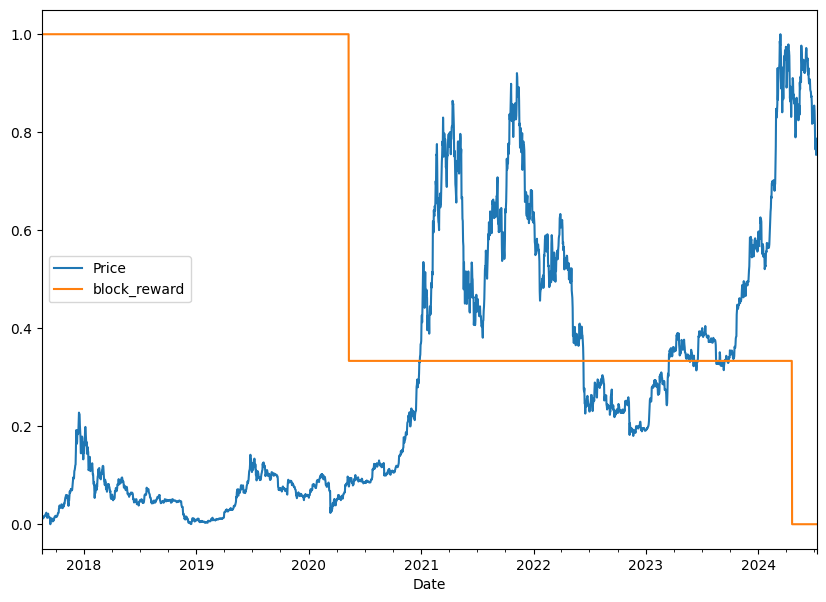

In [82]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
scaled_price_block_df = pd.DataFrame(minmax_scale(btc_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=btc_prices_block.columns,
                                     index=btc_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset 

In [83]:
HORIZON = 1
WINDOW_SIZE = 7

In [84]:
btc_prices_windowed = btc_prices_block.copy()

for i in range(WINDOW_SIZE):
  btc_prices_windowed[f"Price+{i+1}"] = btc_prices_windowed["Price"].shift(periods=i+1)
btc_prices_windowed.head(10)

Price block_reward  Price+1  Price+2  Price+3  Price+4  Price+5  \
Date                                                                            
2017-08-17  4285.08         12.5      NaN      NaN      NaN      NaN      NaN   
2017-08-18  4108.37         12.5  4285.08      NaN      NaN      NaN      NaN   
2017-08-19  4139.98         12.5  4108.37  4285.08      NaN      NaN      NaN   
2017-08-20  4086.29         12.5  4139.98  4108.37  4285.08      NaN      NaN   
2017-08-21  4016.00         12.5  4086.29  4139.98  4108.37  4285.08      NaN   
2017-08-22  4040.00         12.5  4016.00  4086.29  4139.98  4108.37  4285.08   
2017-08-23  4114.01         12.5  4040.00  4016.00  4086.29  4139.98  4108.37   
2017-08-24  4316.01         12.5  4114.01  4040.00  4016.00  4086.29  4139.98   
2017-08-25  4280.68         12.5  4316.01  4114.01  4040.00  4016.00  4086.29   
2017-08-26  4337.44         12.5  4280.68  4316.01  4114.01  4040.00  4016.00   

            Price+6  Price+7  
Date                          
2017-08-17      NaN      NaN  
2017-08-18      NaN      NaN  
2017-08-19      NaN      NaN  
2017-08-20      NaN      NaN  
2017-08-21      NaN      NaN  
2017-08-22      NaN      NaN  
2017-08-23  4285.08      NaN  
2017-08-24  4108.37  4285.08  
2017-08-25  4139.98  4108.37  
2017-08-26  4086.29  4139.98

Remove the NaN values using pandas dropna() method, this equivalent to starting our windowing function at ```sample 0 (the first sample) + WINDOW_SIZE```.

In [85]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = btc_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = btc_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

block_reward      Price+1      Price+2      Price+3      Price+4  \
Date                                                                           
2017-08-24          12.5  4114.009766  4040.000000  4016.000000  4086.290039   
2017-08-25          12.5  4316.009766  4114.009766  4040.000000  4016.000000   
2017-08-26          12.5  4280.680176  4316.009766  4114.009766  4040.000000   
2017-08-27          12.5  4337.439941  4280.680176  4316.009766  4114.009766   
2017-08-28          12.5  4310.009766  4337.439941  4280.680176  4316.009766   

                Price+5      Price+6      Price+7  
Date                                               
2017-08-24  4139.979980  4108.370117  4285.080078  
2017-08-25  4086.290039  4139.979980  4108.370117  
2017-08-26  4016.000000  4086.290039  4139.979980  
2017-08-27  4040.000000  4016.000000  4086.290039  
2017-08-28  4114.009766  4040.000000  4016.000000

In [86]:
y.head()

Date
2017-08-24    4316.009766
2017-08-25    4280.680176
2017-08-26    4337.439941
2017-08-27    4310.009766
2017-08-28    4386.689941
Name: Price, dtype: float32

In [87]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2009, 2009, 503, 503)

# Model 6: Dense (multivariate time series)

In [88]:
# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
model_6 = tf.keras.models.load_model("../models/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 338us/step - loss: 543.2411


738.4317016601562

In [90]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("../models/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 386us/step - loss: 548.8828 - mae: 548.8828


[744.3855590820312, 744.3855590820312]

In [91]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 969us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([24273.111, 24020.674, 23248.148, 23188.43 , 23484.994, 23482.482,
       23205.469, 23536.998, 23503.826, 22532.357], dtype=float32)>

In [92]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

Mean Absolute Error (MAE): 738.4317
Mean Squared Error (MSE): 1411225.5000
Root Mean Squared Error (RMSE): 1187.9501
R^2 Score: 0.9946


{'MAE': 738.4317,
 'MSE': 1411225.5,
 'RMSE': 1187.9501,
 'R2': 0.9945761561393738}

In [93]:
model_1_results

{'MAE': 744.3855304112824,
 'MSE': 1402107.5336500215,
 'RMSE': 1184.1062172161844,
 'R2': 0.9946111858246435}

In [94]:
# The index of the Series will be the same as the index of 'X_test'
model_6_preds_series = pd.Series(model_6_preds.numpy(), index=X_test.index)

# Assign a name to the Series
model_6_preds_series.name = 'Price'

# Display the first few rows of the predictions
print(model_6_preds_series.head())

Date
2023-02-23    24273.111328
2023-02-24    24020.673828
2023-02-25    23248.148438
2023-02-26    23188.429688
2023-02-27    23484.994141
Name: Price, dtype: float32


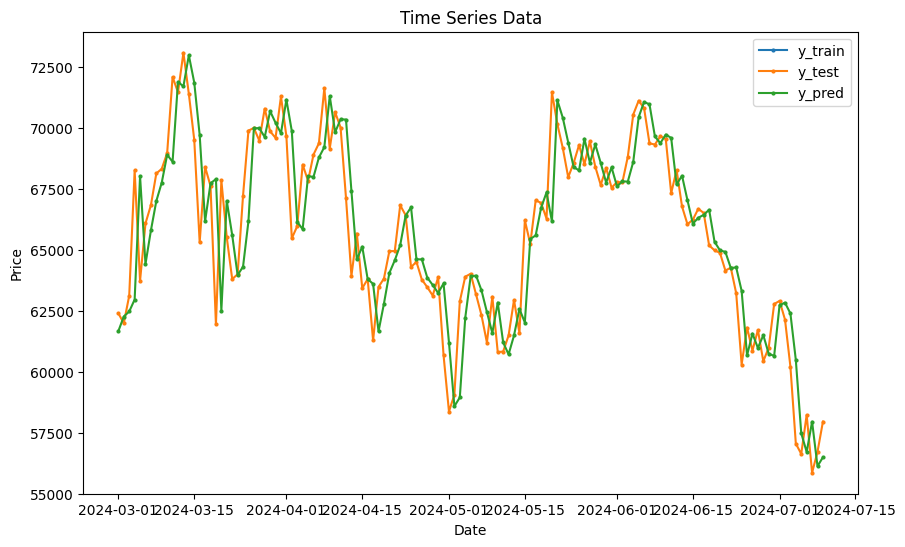

In [95]:
start = pd.to_datetime("2024-03-01")
custom_plot_series(y_train, y_test, model_6_preds_series, start=start, marker_size=2)

# Model 7: N-BEATS algorithm

Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437)

## Building and testing an N-BEATS block layer

In [96]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [97]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.0913095   0.03341006 -0.13884564 -0.1064539   0.04225748 -0.25676274
  0.6772785 ]
Forecast: 0.6752989292144775


## Preparing data for the N-BEATS algorithm using tf.data

In [98]:
HORIZON = 1
WINDOW_SIZE = 7

In [99]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
btc_prices.head()

Price
Date               
2017-08-17  4285.08
2017-08-18  4108.37
2017-08-19  4139.98
2017-08-20  4086.29
2017-08-21  4016.00

In [100]:
# Add windowed columns
btc_prices_nbeats = btc_prices.copy()
for i in range(WINDOW_SIZE):
  btc_prices_nbeats[f"Price+{i+1}"] = btc_prices_nbeats["Price"].shift(periods=i+1)
btc_prices_nbeats.dropna().head()

Price  Price+1  Price+2  Price+3  Price+4  Price+5  Price+6  \
Date                                                                        
2017-08-24  4316.01  4114.01  4040.00  4016.00  4086.29  4139.98  4108.37   
2017-08-25  4280.68  4316.01  4114.01  4040.00  4016.00  4086.29  4139.98   
2017-08-26  4337.44  4280.68  4316.01  4114.01  4040.00  4016.00  4086.29   
2017-08-27  4310.01  4337.44  4280.68  4316.01  4114.01  4040.00  4016.00   
2017-08-28  4386.69  4310.01  4337.44  4280.68  4316.01  4114.01  4040.00   

            Price+7  
Date                 
2017-08-24  4285.08  
2017-08-25  4108.37  
2017-08-26  4139.98  
2017-08-27  4086.29  
2017-08-28  4016.00

In [101]:
# Make features and labels
X = btc_prices_nbeats.dropna().drop("Price", axis=1)
y = btc_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2009, 2009, 503, 503)

In [102]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Setting up hyperparameters for N-BEATS algorithm

> üìñ **Resource**: The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the N-BEATS paper.

In [103]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

## Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True`.
    * `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [104]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1),
                      create_model_checkpoint(model_name=model_7.name)])


Epoch 215: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 315: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 32min 1s, sys: 2min 13s, total: 34min 15s
Wall time: 24min 14s


In [105]:
model_7 = tf.keras.models.load_model("../models/model_7_N-BEATS.keras")
model_7.evaluate(X_test, y_test)

/Users/lucas/anaconda3/envs/btc-prediction/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'InitialBlock', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/lucas/anaconda3/envs/btc-prediction/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'NBeatsBlock_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/lucas/anaconda3/envs/btc-prediction/lib/python3.10/site-packages/keras/src/layers/

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - loss: 558.2206 - mae: 558.2206 - mse: 786016.9375


[755.6006469726562, 755.6006469726562, 1444862.5]

In [106]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 473ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([24297.252, 24054.68 , 23458.445, 23297.307, 23588.082, 23555.1  ,
       23297.732, 23490.27 , 23453.402, 22724.02 ], dtype=float32)>

In [107]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

Mean Absolute Error (MAE): 755.5999
Mean Squared Error (MSE): 1444859.7219
Root Mean Squared Error (RMSE): 1202.0232
R^2 Score: 0.9944


{'MAE': 755.5999270004969,
 'MSE': 1444859.721893143,
 'RMSE': 1202.023178600622,
 'R2': 0.9944468734644978}

## Plotting the N-BEATS architecture we've created

In [108]:
# Plot the N-BEATS model and inspect the architecture
plot_model(model_7,
           show_layer_names=True,
           to_file=f"{model_7.name}.png")

# Model 8: Creating an ensemble (stacking different models together)

In [110]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [111]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 308: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 756: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 856: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 750: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 850: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 148: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 494: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 500: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 600: ReduceLROnPl

## Making predictions with an ensemble model

In [112]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [113]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 29ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

<tf.Tensor: shape=(15, 503), dtype=float32, numpy=
array([[24108.135, 24041.951, 23223.697, ..., 58247.72 , 56274.32 ,
        57112.613],
       [24266.158, 23940.47 , 23278.1  , ..., 58223.98 , 55977.008,
        56651.58 ],
       [24205.805, 23966.766, 23223.281, ..., 58115.258, 56079.668,
        56718.88 ],
       ...,
       [24178.756, 23978.326, 23310.787, ..., 58154.78 , 56243.05 ,
        56551.812],
       [24160.377, 23900.602, 23339.922, ..., 57374.984, 56812.797,
        56801.996],
       [24166.479, 24010.332, 23238.322, ..., 58084.664, 56298.113,
        56329.516]], dtype=float32)>

In [114]:
ensemble_preds.shape

TensorShape([15, 503])

In [115]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median.shape

(503,)

In [118]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)

Mean Absolute Error (MAE): 745.3969
Mean Squared Error (MSE): 1391648.7532
Root Mean Squared Error (RMSE): 1179.6816
R^2 Score: 0.9947


In [121]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

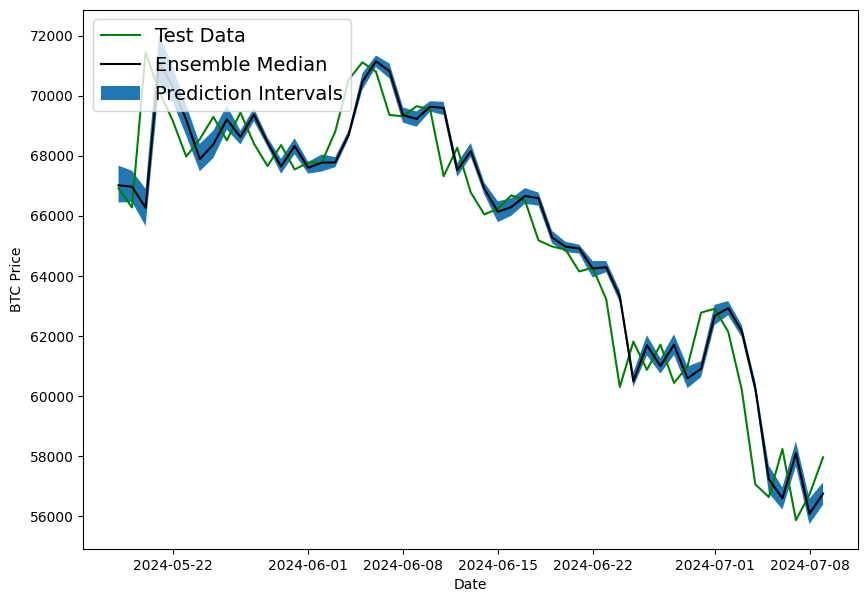

In [137]:
# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=450
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

# Model 9: Train a model on the full historical data to make predictions into future

In [138]:
btc_prices_windowed.head()

Price block_reward  Price+1  Price+2  Price+3  Price+4  Price+5  \
Date                                                                            
2017-08-17  4285.08         12.5      NaN      NaN      NaN      NaN      NaN   
2017-08-18  4108.37         12.5  4285.08      NaN      NaN      NaN      NaN   
2017-08-19  4139.98         12.5  4108.37  4285.08      NaN      NaN      NaN   
2017-08-20  4086.29         12.5  4139.98  4108.37  4285.08      NaN      NaN   
2017-08-21  4016.00         12.5  4086.29  4139.98  4108.37  4285.08      NaN   

            Price+6  Price+7  
Date                          
2017-08-17      NaN      NaN  
2017-08-18      NaN      NaN  
2017-08-19      NaN      NaN  
2017-08-20      NaN      NaN  
2017-08-21      NaN      NaN

In [142]:
# Train model on entire data to make prediction for the next day 
X_all = btc_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = btc_prices_windowed.dropna()["Price"].to_numpy()

In [143]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [144]:
# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

## Make predictions on the future

In [173]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [174]:
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [175]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step
Predicting on: 
 [60208.58 57050.01 56628.79 58230.13 55857.81 56714.62 57952.01] -> Prediction: 59116.5625

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step
Predicting on: 
 [57050.01   56628.79   58230.13   55857.81   56714.62   57952.01
 59116.5625] -> Prediction: 57491.6640625

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step
Predicting on: 
 [56628.79      58230.13      55857.81      56714.62      57952.01
 59116.5625    57491.6640625] -> Prediction: 57289.65625

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step
Predicting on: 
 [58230.13      55857.81      56714.62      57952.01      59116.5625
 57491.6640625 57289.65625  ] -> Prediction: 57678.828125

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step
Predicting on: 
 [55857.81      56714.62      57952.01      59116.5625    57491.6640625
 57289.

In [176]:
len(future_forecast)

14

# Plot future forecasts

In [177]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [178]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = btc_prices.index[-1]
last_timestep

Timestamp('2024-07-09 00:00:00')

In [179]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13',
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17',
       '2024-07-18', '2024-07-19', '2024-07-20', '2024-07-21',
       '2024-07-22', '2024-07-23'], dtype='datetime64[D]')

In [180]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices["Price"].iloc[-1])
next_time_steps, future_forecast

(array(['2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
        '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16',
        '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20',
        '2024-07-21', '2024-07-22', '2024-07-23'], dtype='datetime64[D]'),
 array([57952.01 , 59116.562, 57491.664, 57289.656, 57678.83 , 56878.832,
        57650.777, 58376.586, 58714.49 , 57828.188, 57688.2  , 57800.688,
        57682.332, 58257.746, 58633.793], dtype=float32))

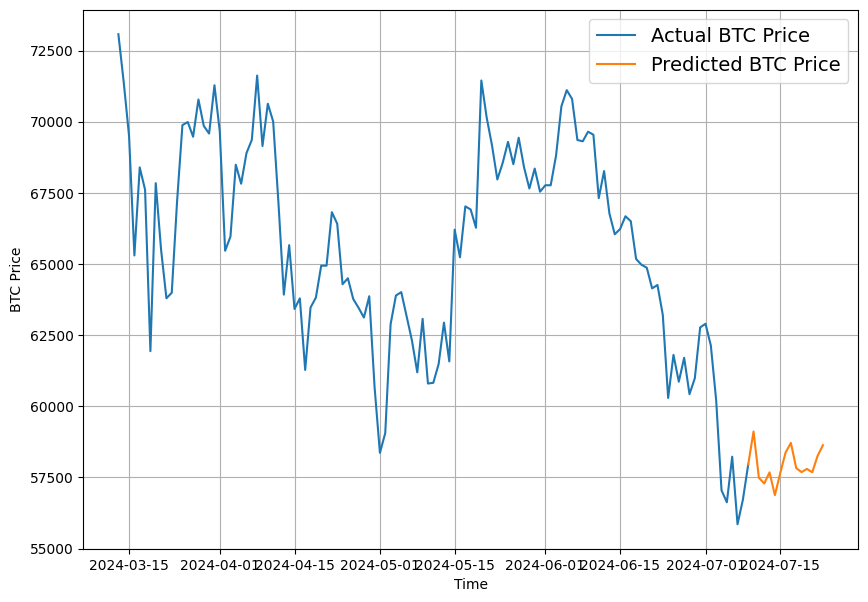

In [184]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(btc_prices.index, btc_prices, start=2400, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

# Compare Models

In [191]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"sktime_model": model_0_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results})
model_results = model_results.T

model_results.head(10)

MAE           MSE         RMSE        R2
sktime_model          3154.655641  1.364281e+07  3693.617399 -1.305366
model_1_dense_w7_h1    744.385530  1.402108e+06  1184.106217  0.994611
model_2_dense_w30_h1   765.203000  1.458406e+06  1207.644739  0.994382
model_3_dense_w30_h7  1569.939180  5.605418e+06  2367.576400  0.978419
model_4_CONV1D        1043.629642  2.109106e+06  1452.276004  0.991894
model_5_LSTM           759.131968  1.437608e+06  1199.002878  0.994475
model_6_multivariate   738.431702  1.411226e+06  1187.950073  0.994576
model_8_NBEATs         755.599927  1.444860e+06  1202.023179  0.994447
model_9_ensemble       745.396912  1.391649e+06  1179.681632  0.994651

In [199]:
metrics = list(model_0_results.keys())
metrics

['MAE', 'MSE', 'RMSE', 'R2']

Sorting model results by MAE and plot them
Sorting model results by MSE and plot them
Sorting model results by RMSE and plot them
Sorting model results by R2 and plot them


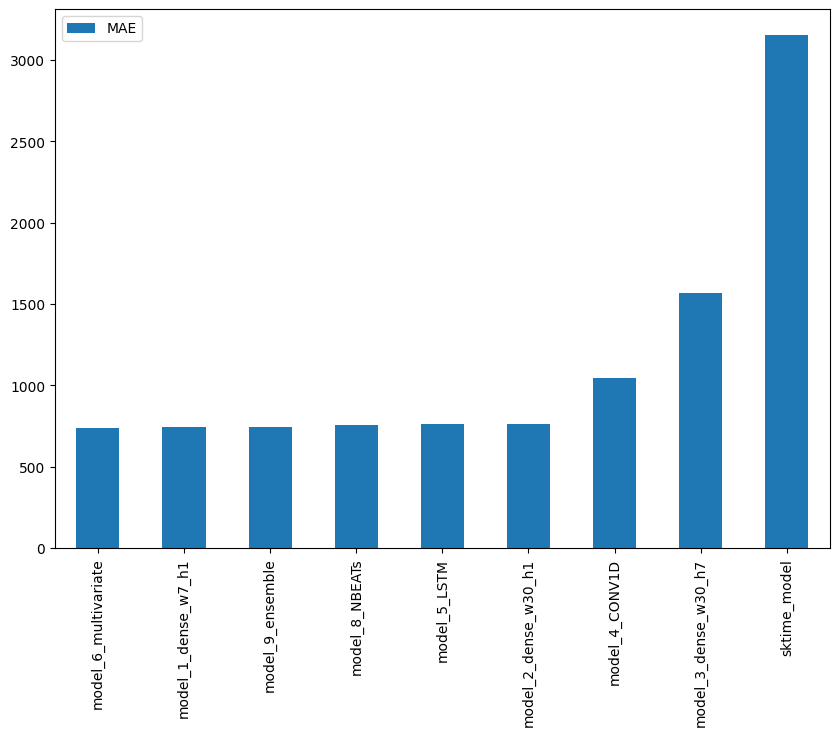

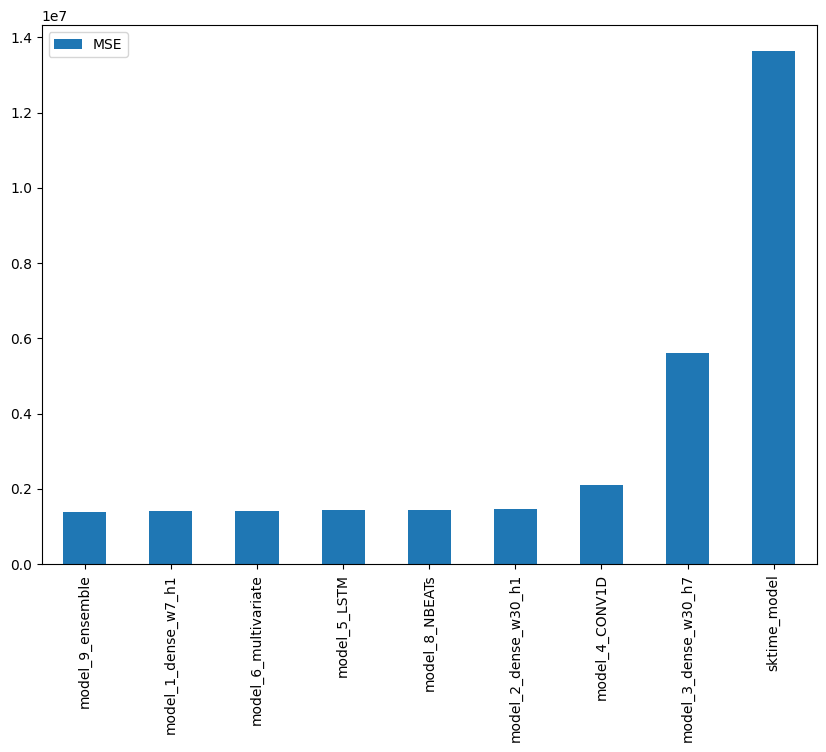

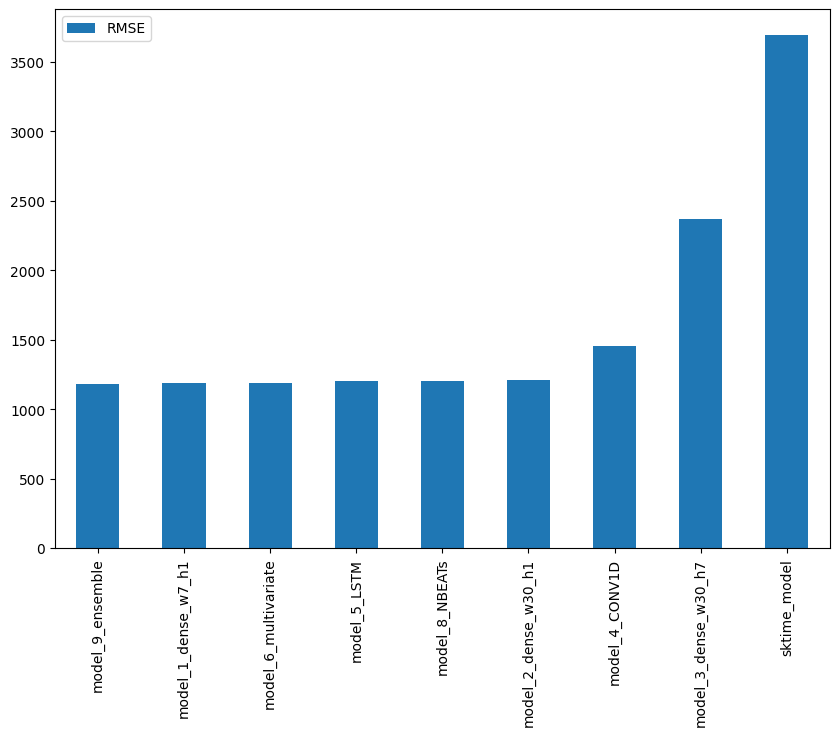

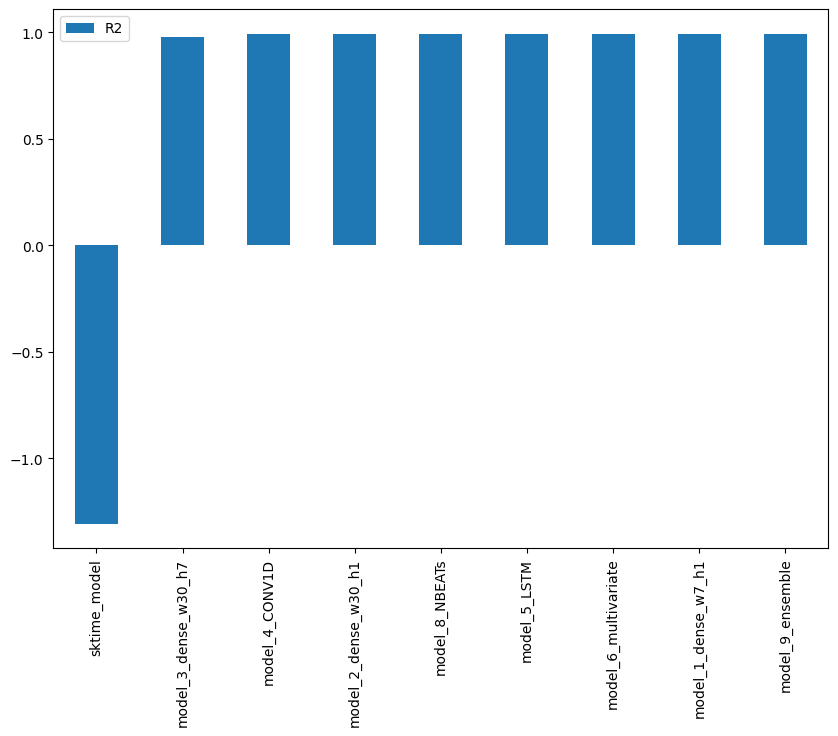

In [211]:
for metric in metrics:
    print(f"Sorting model results by {metric} and plot them")
    model_results[[metric]].sort_values(by=metric).plot(figsize=(10, 7), kind="bar")